# Feature and Structure Independence

## Load Real-World Dataset

In [28]:
g_complete = nx.read_edgelist("/Users/niklasstoehr/Programming/thesis/4_real_attr/data/amazon/edges_sample.csv",delimiter = ",")
a_complete = nx.adjacency_matrix(g_complete)


In [102]:
sampleArgs = {"sample": "biased_random_walk", "jump_bias": "random_walk_induced_graph_sampling", "n": 1000, "p": 20.0, "q": 100.0, "source_starts": 2, "source_returns": 4, "depth": 2}

##exact_n: forestfire, random_walk_induced_graph_sampling, random_walk_sampling_with_fly_back, adjacency, select
##approx_n: snowball, bfs, walk, jump

def get_graph(sampleArgs,g_complete,a_complete):
    
    if sampleArgs["sample"] == "biased_random_walk":
        sampler = Base_Samplers(g_complete,a_complete)
        #sampler = Base_Samplers(g_complete,a_complete)
        g = sampler.biased_random_walk(sampleArgs["n"], sampleArgs["p"], sampleArgs["q"])
    
    #nx.set_node_attributes(g, node_attr_dict, "citations")
    #f = list(nx.get_node_attributes(g,'citations').values())
    return g

start_time = time.time()
g = get_graph(sampleArgs, g_complete, a_complete)

print("-- n_max should be >=", len(g), "--")
print("-- function get_graph takes %s secs --" % round((time.time() - start_time),  5))

#if len(g) <= 200:
#    nx.draw(g, node_color = color_map, with_labels = False)

-- n_max should be >= 53 --
-- function get_graph takes 0.07523 secs --


### Libs

In [3]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools
import time
import math
import sys

## Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 
import scipy.stats as stats
from scipy.stats import wasserstein_distance

## Data Wrangling
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
orig_cmap = plt.cm.PuBu

Using TensorFlow backend.


### Supporting Function

In [4]:
## supporting functions
from support.preprocessing import sort_adj, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, pad_attr, unpad_attr, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single_features, generate_manifold_features
from support.latent_space import vis2D, visDistr
from support.comparing import compare_manifold_adjacency, compare_topol_manifold
from support.plotting import shiftedColorMap

## graph sampling
from sampling import ForestFire, Metropolis_Hastings, Random_Walk, Snowball, Ties, Base_Samplers

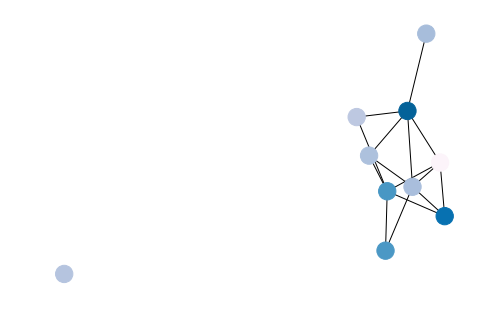

In [5]:
def get_graph(n,p,draw): 

    g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)

    if draw:
        f = np.random.rand(n)
        orig_cmap = plt.cm.PuBu
        fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
        nx.draw(g, node_color=f, font_color='white', cmap = fixed_cmap)
        plt.show()
    
    return g

g = get_graph(n = 10, p = 0.4, draw = True)

In [6]:
def generate_features(dataArgs, g, n, p):
    
        if dataArgs["feature_dependence"] == "random":
            f = np.random.rand(n, dataArgs["n_features"])                   ## float
            #F[i] = np.random.randint(2, size=(dataArgs["n_max"],dataArgs["n_features"]))   ## int
            
        if dataArgs["feature_dependence"] == "norm_degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f) / (max(f)+1)
                f = np.reshape(f, (f.shape[-1],1))
                
        
        if dataArgs["feature_dependence"] == "degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f+1) / (dataArgs["n_max"]+1)
                f = np.reshape(f, (f.shape[-1],1))
    
                
        if dataArgs["feature_dependence"] == "uniform":
            if dataArgs["n_features"] == 1:
                
                f = np.ones((len(g)))  
                f = f * np.random.rand()
                f = np.reshape(f, (f.shape[-1],1))
                
                
        if dataArgs["feature_dependence"] == "p":  
            if dataArgs["n_features"] == 1:
                f = np.ones((n , 1)) * p
                
        return f

In [7]:
def prepare_in_out(diag_offset, A_shape, F_shape):

    if diag_offset == 0:  # matrix input
        return (F_shape[1], A_shape[0]) , (F_shape[1], A_shape[0])


In [8]:
def generate_data(dataArgs): 
    
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F = np.zeros((dataArgs["n_graphs"], dataArgs["n_max"], dataArgs["n_features"]))
    print("feature_dependence:",dataArgs["feature_dependence"] )
    
    
    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):
        
        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

            
        p = np.random.rand(1)  # float in range 0 - 1 
        g = get_graph(n, p, draw = False)
                     
        #nx.draw(g, cmap=plt.get_cmap('PuBu'), node_color=np.squeeze(f), font_color='white')
        #plt.show()
        
        g, a = sort_adj(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
        
        
        ## Generate / Load Node Features ______________________________________________
        f = generate_features(dataArgs, g, n, p)
        
        ## pad features with zeroes
        f = pad_attr(f, dataArgs)

        
        ## Build Data Arrays___________________________________________________

        F[i] = f
        G[i] = a_transformed


    ## Input and Output Size ___________________________________________________________

    input_shape, output_shape = prepare_in_out(dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]), F.shape)
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale features in F for smoother training
    #scaler = MinMaxScaler()
    #scaler.fit(F)
    #F = scaler.transform(F)
    
    return G, F, input_shape,output_shape
    
dataArgs = {"n_graphs": 1000, "n_max": 30, "feature_dependence": "uniform", "fix_n": False, "diag_offset": 0, "diag_value": 1, "clip": True, "n_features": 1}  #"diag_offset" - 1 == full adjacency
G, F, input_shape, output_shape = generate_data(dataArgs)

feature_dependence: uniform



input_shape: (30, 465) , output_shape: (30, 465)


# beta-VAE Model

In [21]:
## libs
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from sklearn.model_selection import train_test_split


class VAE():

    # reparameterization trick
    # instead of sampling from Q(z|X), sample eps = N(0,I)
    # then z = z_mean + sqrt(var)*eps

    def sampling(self, args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon



    def __init__(self, modelArgs, trainArgs, fg_train, f_train, g_train, fg_test, f_test, g_test):

        ## MODEL ______________________________________________________________
        
        
        ## 1.1) build attr encoder model
        attr_input = Input(shape= (modelArgs["input_shape"][0],), name='attr_input')
        x1 = Dense(12, activation='relu')(attr_input)
        x1 = Dense(8, activation='relu')(x1)        
        
        ## 1.2) build topol encoder model
        topol_input = Input(shape= (modelArgs["input_shape"][1],), name='topol_input')
        x2 = Dense(64, activation='relu')(topol_input)
        x2 = Dense(32, activation='relu')(x2)
        x2 = Dense(8, activation='relu')(x2)
        
        
        encoder_combined = concatenate([x1, x2])
        z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(encoder_combined)
        z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(encoder_combined)
        
        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])
        
        latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
        
        ## 2.1) build attr decoder model
        y1 = Dense(8, activation='relu')(latent_inputs)
        y1 = Dense(32, activation='relu')(y1)
        y1 = Dense(64, activation='relu')(y1)
        attr_output = Dense(modelArgs["output_shape"][0], activation='sigmoid')(y1)
        
        ## 2.2) build topol decoder model
        y2 = Dense(8, activation='relu')(latent_inputs)
        y2 = Dense(32, activation='relu')(y2)
        y2 = Dense(64, activation='relu')(y2)
        topol_output = Dense(modelArgs["output_shape"][1], activation='sigmoid')(y2)
    


    
        ## INSTANTIATE___________________________________

        ## 1) instantiate topol encoder model
        attr_topol_encoder = Model([attr_input, topol_input], [z_mean, z_log_var, z], name='attr_topol_encoder')
        attr_topol_encoder.summary()

        ## 2) instantiate topology decoder model
        attr_topol_decoder = Model(latent_inputs, [attr_output, topol_output], name='attr_topol_decoder')
        attr_topol_decoder.summary()
        
        ## 3) instantiate VAE model
        attr_topol_outputs = attr_topol_decoder(attr_topol_encoder([attr_input, topol_input])[2])
        vae = Model([attr_input, topol_input], attr_topol_outputs, name='vae')

    

        ## LOSS FUNCTIONS ______________________________________
        
        def loss_func(y_true, y_pred):
            
            y_true_attr = y_true[0]
            y_pred_attr = y_pred[0]
            
            y_true_topol = y_true[1]
            y_pred_topol = y_pred[1]
            

            ## ATTR RECONSTRUCTION LOSS_______________________            
            ## mean squared error
            attr_reconstruction_loss = mse(K.flatten(y_true_attr), K.flatten(y_pred_attr))
            attr_reconstruction_loss *= modelArgs["input_shape"][0]
            
            ## TOPOL RECONSTRUCTION LOSS_______________________
            ## binary cross-entropy
            topol_reconstruction_loss = binary_crossentropy(K.flatten(y_true_topol), K.flatten(y_pred_topol))
            topol_reconstruction_loss *= modelArgs["input_shape"][0]
                     
            ## KL LOSS _____________________________________________
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            loss = K.mean(trainArgs["loss_weights"][0] * attr_reconstruction_loss + trainArgs["loss_weights"][1] * topol_reconstruction_loss + trainArgs["loss_weights"][2] * kl_loss)
            
            return loss
        
        
    
    
    
        ## MODEL COMPILE______________________________________________
        
        #vae.compile(optimizer='adam', loss={"attr_decoder": attr_loss_func, "topol_decoder": topol_loss_func}, loss_weights=trainArgs["loss_weights"])
        vae.compile(optimizer='adam', loss= loss_func) #, loss_weights=trainArgs["loss_weights"])
        vae.summary()
        
        

        ## TRAIN______________________________________________

        # load the autoencoder weights

        if trainArgs["weights"] == "load":

            vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

        # train the autoencoder

        elif trainArgs["weights"] == "train":

            # Set callback functions to early stop training and save the best model so far
            callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5",save_best_only=True)]

            #vae.fit([f_train, g_train], {"attr_decoder": f_train, "topol_decoder": g_train}, epochs=trainArgs["epochs"],batch_size=trainArgs["batch_size"], callbacks=callbacks,validation_data=([f_test, g_test], {"attr_decoder": f_test, "topol_decoder": g_test}))
            vae.fit([f_train, g_train], [f_train, g_train], epochs=trainArgs["epochs"],batch_size=trainArgs["batch_size"], callbacks=callbacks,validation_data=([f_test, g_test], [f_test, g_test]))
            #vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

            self.model = (attr_topol_encoder, attr_topol_decoder)

### Data Split

In [22]:
trainArgs = {"loss_weights": [100,1,5], "weights": "train", "early_stop": 2, "batch_size": 8, "epochs": 50, "data_split": 0.2}
modelArgs = {"nn_architecture": "mlp", "latent_dim": 2, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape, "param_loss": False,}

from support.keras_dgl.utils import *
from support.keras_dgl.layers import MultiGraphCNN

## Train and Validation Split _______________________________________________

F = np.squeeze(F) ## remove last dimension
g_train, g_test, f_train, f_test = train_test_split(G, F, test_size=trainArgs["data_split"], random_state=1, shuffle=True)

fg_train = np.concatenate((f_train, g_train), axis=1)
fg_test = np.concatenate((f_test, g_test), axis=1)

data = (f_test, g_test)

### Train

In [24]:
vae = VAE(modelArgs, trainArgs, fg_train, f_train, g_train, fg_test, f_test, g_test)
models = vae.model 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
topol_input (InputLayer)        (None, 465)          0                                            
__________________________________________________________________________________________________
attr_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 64)           29824       topol_input[0][0]                
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 12)           372         attr_input[0][0]                 
__________________________________________________________________________________________________
dense_43 (

800/800 [==============================] - 0s 370us/step - loss: 428.4326 - attr_topol_decoder_loss: 240.9969 - val_loss: 558.5562 - val_attr_topol_decoder_loss: 329.0182
Epoch 11/50
800/800 [==============================] - 0s 448us/step - loss: 489.4702 - attr_topol_decoder_loss: 301.3028 - val_loss: 515.3439 - val_attr_topol_decoder_loss: 320.1868
Epoch 12/50
800/800 [==============================] - 0s 459us/step - loss: 419.9252 - attr_topol_decoder_loss: 258.6348 - val_loss: 529.6170 - val_attr_topol_decoder_loss: 315.4152
Epoch 13/50
800/800 [==============================] - 0s 443us/step - loss: 453.9210 - attr_topol_decoder_loss: 290.9067 - val_loss: 482.8051 - val_attr_topol_decoder_loss: 312.5481
Epoch 14/50
800/800 [==============================] - 0s 385us/step - loss: 381.5686 - attr_topol_decoder_loss: 226.5755 - val_loss: 480.5054 - val_attr_topol_decoder_loss: 298.4665
Epoch 15/50
800/800 [==============================] - 0s 478us/step - loss: 440.5715 - attr_topo

# Analysis

### Latent Distribution

In [ ]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

### Generate Single

In [ ]:
analyzeArgs = {"z": [0,1], "activations": [3,20], "normalize_feature": False}
generate_single_features(analyzeArgs, modelArgs, dataArgs, models, orig_cmap)

### Generate Manifold

In [96]:
## DECODER - Latent Space Interpolation____________________________

def generate_manifold_features(analyzeArgs, modelArgs, dataArgs, models, data, orig_cmap, batch_size=128):
    print("latent dimensions:", modelArgs["latent_dim"])
    (encoder, decoder) = models

    (f_test, g_test) = data
    z_mean, z_log_var, _ = encoder.predict([f_test, g_test], batch_size=batch_size)

    ## Latent Space Dimension is 2 ______________________

    if modelArgs["latent_dim"] == 2:

        ## 1) create adjacency plots_______________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n, 3))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "range":
            grid_y = np.linspace(4, 30, analyzeArgs["size_of_manifold"], dtype = int)[::-1]
            grid_x = np.linspace(2.0, 10.0,analyzeArgs["size_of_manifold"])  ## revert

        ## 2) create graph plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8), dpi = 300)
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        sampleArgs["n"] = dataArgs["n_max"]
        g_presample = get_graph(sampleArgs, g_complete, a_complete)
        print("len(g_presample)", len(g_presample), "\n")
        
        sampleArgs["p"] = 10
        sampleArgs["q"] = 200
        
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                
                sampleArgs["n"] = yi
                g = get_graph(sampleArgs, g_presample, a_complete)
                

                #topology = nx.average_clustering(g)
                
                import time    
                start_time = time.clock()
                
                while (len(g) < sampleArgs["n"] - 7):
                    #g = get_graph(sampleArgs, g_complete, a_complete)
                    
                    g = get_graph(sampleArgs, g_complete, a_complete)
                    #topology = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())
                    #topology = nx.average_clustering(g)
                    
                    if time.clock() > start_time + 1.0:
                        break
                
                g, a = sort_adj(g)
                
                #reconstructed_f = np.ones((len(g)))
                #degrees = np.asarray([x[1] for x in g.degree()], dtype = float)
                degrees = np.random.normal(0.4, 0.05, len(g))
                degrees += (np.asarray([x for x in list(nx.clustering(g).values())])) / xi
                
                reconstructed_f = degrees #* yi
                #print(len(g), reconstructed_f)
                print(reconstructed_f)
                

                a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
                #a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
                
                
                ## build fixed cmap
                fixed_cmap = shiftedColorMap(orig_cmap, start=min(reconstructed_f), midpoint=0.5,stop=max(reconstructed_f), name='fixed')
                #fixed_cmap = shiftedColorMap(orig_cmap, start=0.0, midpoint=0.5,stop=1.0, name='fixed')
                
                ## adjust colour reconstructed_a_padded according to features
                feature_a = np.copy(a)
                feature_a = np.tile(feature_a[:, :, None], [1, 1, 3])  ## broadcast 1 channel to 3
                

                for node in range(0, len(g)):
                    color = fixed_cmap(reconstructed_f[node])[:3]
                    
                    feature_a[node, :node + 1] = feature_a[node, :node + 1] * color
                    feature_a[:node, node] = feature_a[:node, node] * color
                
                
                ## 1) create adjacency plots_____________________________________

                figure[i * n: (i + 1) * n,
                j * n: (j + 1) * n] = feature_a

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])
                nx.draw(g, node_size=12, node_color=reconstructed_f, width=0.2, font_color='white', cmap=fixed_cmap)
                axs[i, j].set_axis_off()

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10), dpi = 300)
        #plt.xticks(pixel_range, sample_range_x)
        #plt.yticks(pixel_range, sample_range_y)
        #plt.xlabel("z_0", fontweight='bold')
        #plt.ylabel("z_1", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.axis('off')
        plt.show()


latent dimensions: 2
len(g_presample) 30 

[0.84505807 0.58664854 0.89075142 0.90692839 0.46965833 0.40203026
 0.31633986 0.31330696 0.66463352 0.86064039 0.72198663 0.83059862
 0.8058004  0.79823568 0.63596691 0.73254589 0.40537943 0.31818191
 0.97902705 0.66932744 0.85693333 0.67979536 0.94667581 0.94096453
 0.86728393 0.39522851]
[0.42283858 0.53744583 0.66328058 0.46158346 0.67146232 0.68638874
 0.68557332 0.60379018 0.66930035 0.72842105 0.60087998 0.45645175
 0.72099485 0.78304673 0.44501596 0.52712109 0.62761093 0.45082289
 0.36902949 0.38947202 0.37863622 0.38798332 0.53554858 0.36151815
 0.44844335 0.47961942 0.42104953 0.44876043 0.48041534 0.43618178]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[0.41043956 0.40448161 0.39395891 0.44178998 0.42700895 0.3876094
 0.42686202 0.40646027 0.55875963 0.62656447 0.58332639 0.66453319
 0.32215583 0.41374899 0.44533058 0.33885976 0.38470977 0.41238497
 0.36615486 0.45414871 0.56629662 0.46684378 0.45865921 0.4140011
 0.37981032 0.36692697 0.43551552 0.5700938  0.53840381 0.37375768]
[0.52502184 0.55830626 0.50154322 0.60237978 0.44258472 0.33936131
 0.44866734 0.50995776 0.44481641 0.40123338 0.54518919 0.51210121
 0.5052572  0.5866758  0.53642386 0.52802256 0.55448754 0.569251
 0.36891978 0.61674735 0.62151477 0.51321769 0.52735911 0.48491964
 0.59907119 0.5341209  0.49078465 0.45878797 0.56378688 0.31934906]
[0.45228911 0.57944294 0.52519576 0.48850159 0.54783252 0.52728612
 0.4868883  0.46051524 0.62217261 0.42926916 0.4189591  0.41720998
 0.36741383 0.4453979  0.57102346 0.59057001 0.29528494 0.54500681
 0.52069822 0.42125138 0.40802283 0.46194274 0.5129078  0.44702693
 0.39921667 0.44708921 0.42582212 0.40504746 0.39091823 0.405042

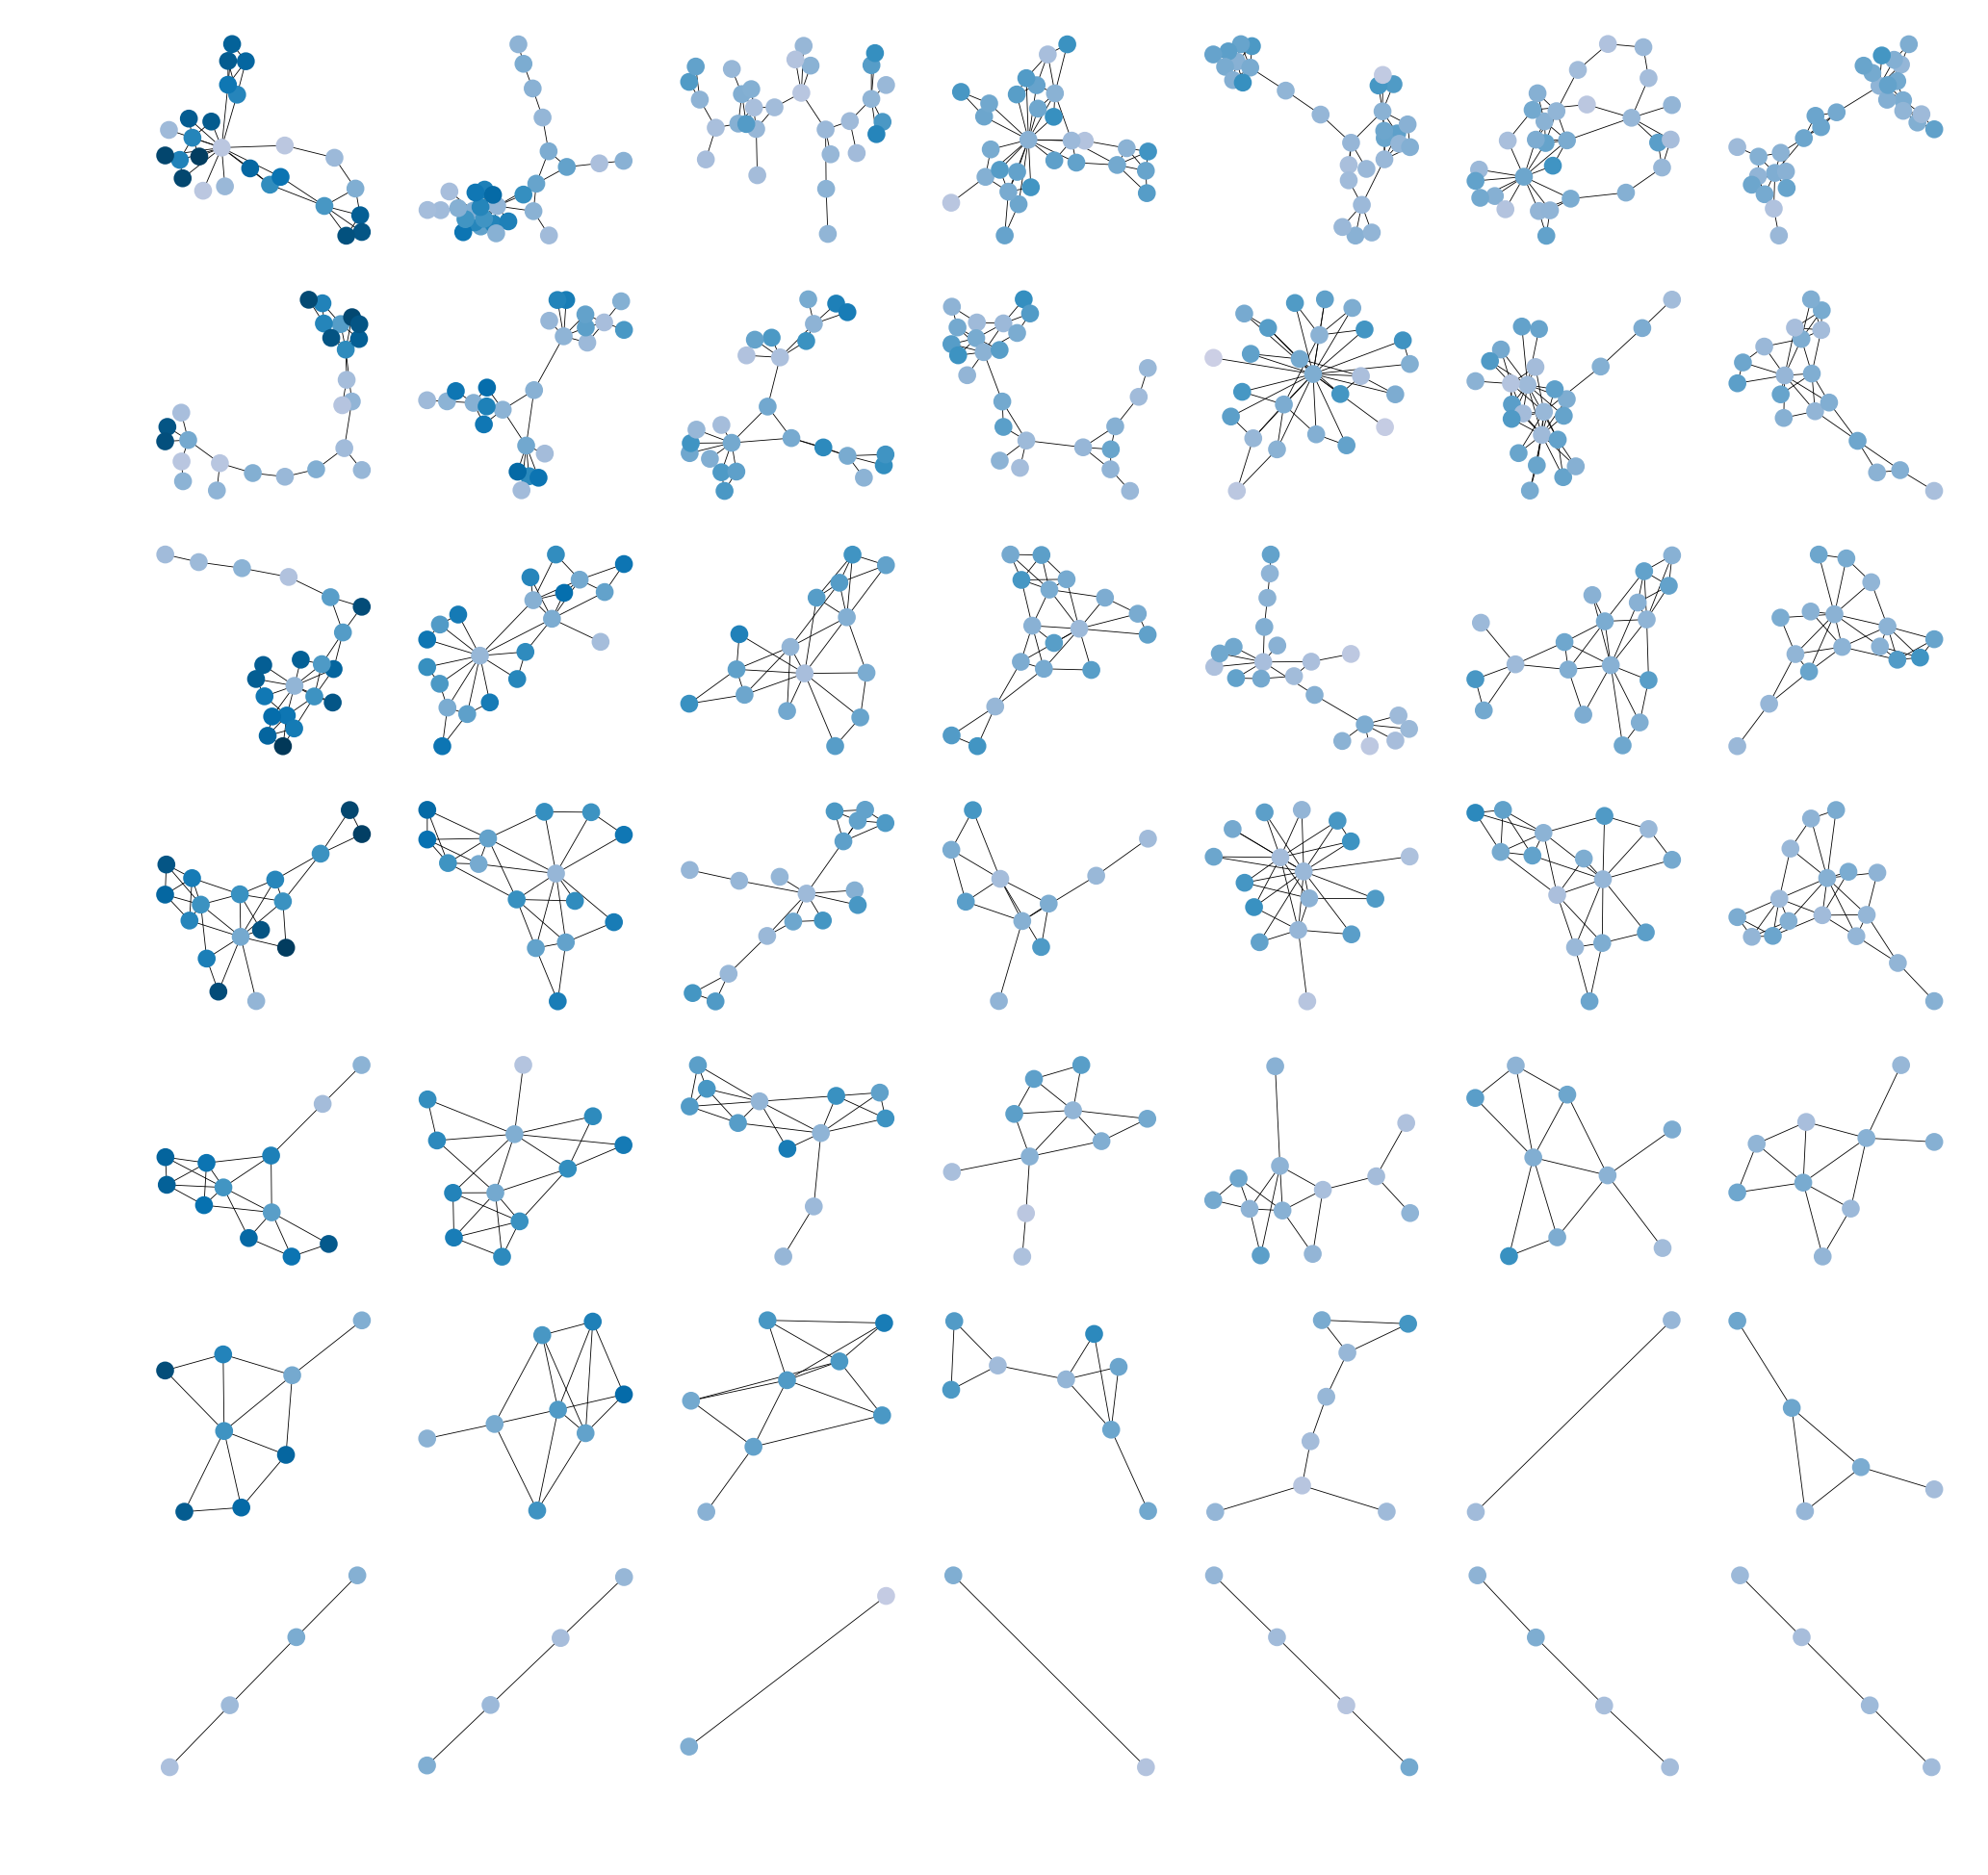

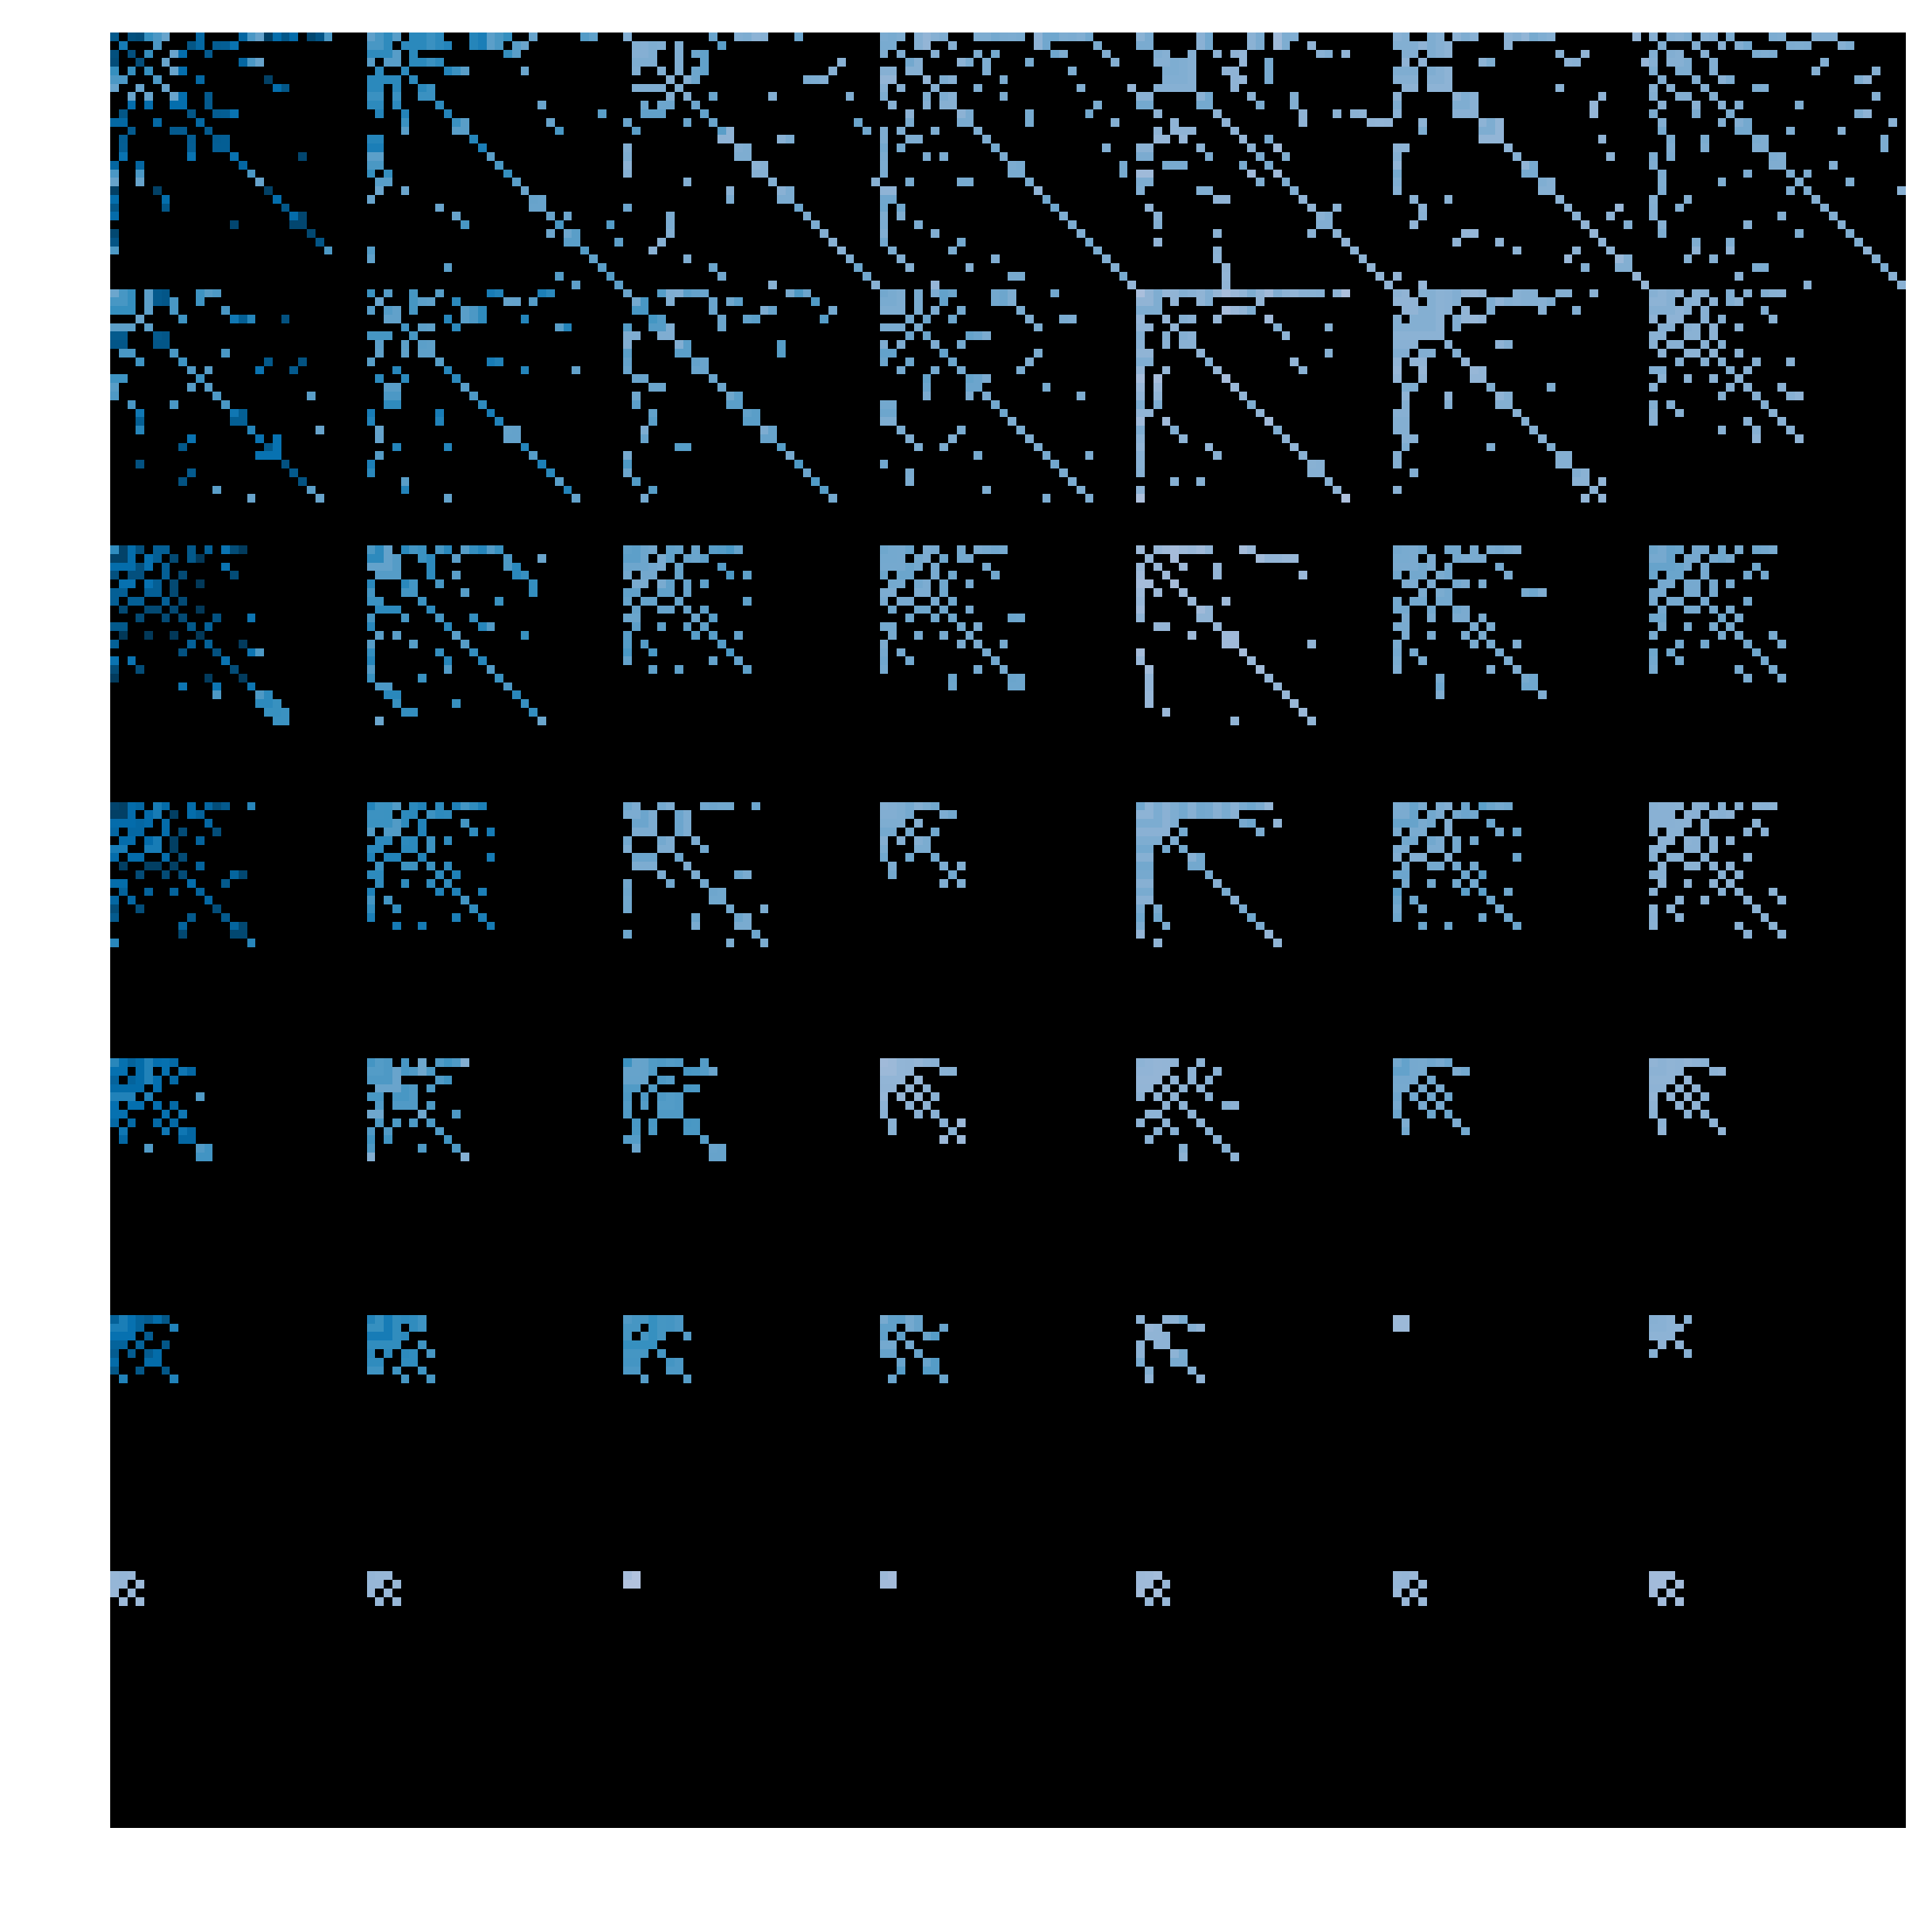

In [101]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 7, "save_plots": False, "normalize_feature": False}
generate_manifold_features(analyzeArgs, modelArgs, dataArgs, models, data, orig_cmap, batch_size=trainArgs["batch_size"])

In [120]:
list(nx.betweenness_centrality(g).values())

[0.0, 0.0]

## Modification (Nullhypothesis Testing)

## Latent Variable Correlation


In [ ]:
def feature_latent_correlation(analyzeArgs, modelArgs, models, data, batch_size=128,model_name="vae_graph"):

    
    ## unpack models and data__________________________
    
    encoder, decoder = models  # trained models
    #F, [A_fil, A] = data
    
    ## generate input network _________________________
    
    g = get_graph(analyzeArgs["n"], analyzeArgs["p"], draw = False) 
    g, a = sort_adj(g)
    a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
    a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
    A = np.reshape(a_transformed, (1, *a_transformed.shape))
    A = np.tile(A, (analyzeArgs["mod_steps"],1))
        
    f = generate_features(dataArgs, g, analyzeArgs["n"], analyzeArgs["p"]) 
    print("original features:\n", f)
    
    F_mod = np.zeros((analyzeArgs["mod_steps"], dataArgs["n_max"], dataArgs["n_features"]))
        
                 
    ## Modify Features__________________________________
                 
    mod_degree = np.linspace(0,dataArgs["n_max"],analyzeArgs["mod_steps"], dtype = int) 
    
    for i, mod in enumerate(mod_degree):
        
        f_mod = np.copy(f)

        if analyzeArgs["f_variation"] == "random":
            for m in range(0, mod):
                swap = np.random.randint(low = 0, high = f_mod.shape[0], size = 2)
                temp = f[swap[0]]
                f_mod[swap[0]] = f_mod[swap[1]]
                f_mod[swap[1]] = temp


        elif analyzeArgs["f_variation"] == "equal":

            mod_ratio = mod / max(mod_degree)
            norm_mean = np.mean(f)

            for i in range(0,len(f_mod)):

                if f_mod[i] > norm_mean:
                    f_mod[i] = f_mod[i] - (mod_ratio * (np.abs(f_mod[i] - norm_mean)))
                else:
                    f_mod[i] = f_mod[i] + (mod_ratio * (np.abs(f_mod[i] - norm_mean )))


        elif analyzeArgs["f_variation"] == "uniform":

            f_mod = np.ones(f_mod.shape[0]) * (mod / max(mod_degree))
            f_mod = np.reshape(f_mod, (f_mod.shape[-1],1))

        ## pad features with zeroes
        f_mod = pad_attr(f_mod, dataArgs)
        F_mod[i] = f_mod    
        

    ## ENCODER ______________________________________________
    z_mean, _, _ = encoder.predict([np.squeeze(F_mod), A], batch_size = batch_size)


    ## Measure the Mutual Information Gap ____________________________________________
    if analyzeArgs["metric"] == "mig":
        mig = compute_mig(mod_degree, np.squeeze(z_mean))
        
        
    ## toDO: measure the correlation between latent variable and the generative factor / features

    ## Visualize Latent Variables x Feature Change ____________________________

    fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= 1, figsize=(10,20))

    for latent_z, row in enumerate(ax):        

            y = z_mean[:,latent_z]
            x = mod_degree / max(mod_degree)
            sns.regplot(x, y, color="steelblue", ax=row, ci = None, x_ci='sd', x_estimator=np.mean)

            ## compute correlation and standardized covariance
            corr = round(pearsonr(x,y)[0],3)
            cov = round(np.cov(x, y)[0][1]/max(x),3)
            std = round(np.std(y),3)
            row.annotate("corr:"+str(corr)+", std:"+str(std), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points', fontweight='bold')

            

    ## add row and column titles _____________________

    rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
    cols = [t for t in ["feature modification percentage"]]

    for axis, col in zip(ax, cols):
        axis.set_title(col, fontweight='bold')

    for axis, row in zip(ax, rows):
        axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')


        
## PLOT RESULTS ________________________________________

dataArgs["feature_dependence"] = "degree"  #"degree", "random", "p"
analyzeArgs = {"n": 5, "p": 0.4, "mod_steps": 1000, "f_variation": "random", "metric": "none", "normalize_feature": False}
feature_latent_correlation(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")